# Homework 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [2]:
# import training set
training_path = 'cs-training.csv'
df_train = pd.read_csv(training_path)

# Fill NaN with columns means
df_train.fillna(value = df_train.mean(), inplace = True)

# Extract dataframe as arrays
# 'Unnamed: 0' is index and 'SeriousDlqin2yrs' is classification variable
X_columns  = df_train.columns.difference(['Unnamed: 0', 'SeriousDlqin2yrs'])
X_train = np.array(df_train[X_columns])
y_train = np.array(df_train['SeriousDlqin2yrs'])

# standardize X
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

length, width = X_train_std.shape

In [3]:
# import test set
X_test_path = 'cs-test.csv'
X_df_test = pd.read_csv(X_test_path)
X_df_test.fillna(value = X_df_test.mean(), inplace = True)
X_test = np.array(X_df_test[X_columns])
X_test_std = sc.transform(X_test)
# import y_test from the probability set
# for those probability >= 0.5, let y_predict be 1 and otherwise 0
y_test_path = 'sampleEntry.csv'
y_df_test = pd.read_csv(y_test_path)
y_test_p = np.array(y_df_test['Probability'])
benchmark = 0.5
y_test_binary = y_test_p >= benchmark

## PCA

In [4]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
explained_variance_ratio = pca.explained_variance_ratio_

In [5]:
cumsum = np.cumsum(explained_variance_ratio)
for i, s in enumerate(cumsum):
    print('The largest {0} components can explain {1:.4f} of variance of the training set'.format(i+1, s))

The largest 1 components can explain 0.2995 of variance of the training set
The largest 2 components can explain 0.4528 of variance of the training set
The largest 3 components can explain 0.5754 of variance of the training set
The largest 4 components can explain 0.6763 of variance of the training set
The largest 5 components can explain 0.7764 of variance of the training set
The largest 6 components can explain 0.8698 of variance of the training set
The largest 7 components can explain 0.9433 of variance of the training set
The largest 8 components can explain 0.9976 of variance of the training set
The largest 9 components can explain 0.9993 of variance of the training set
The largest 10 components can explain 1.0000 of variance of the training set


So we choose 6 components which can explain over 80% of the variance.

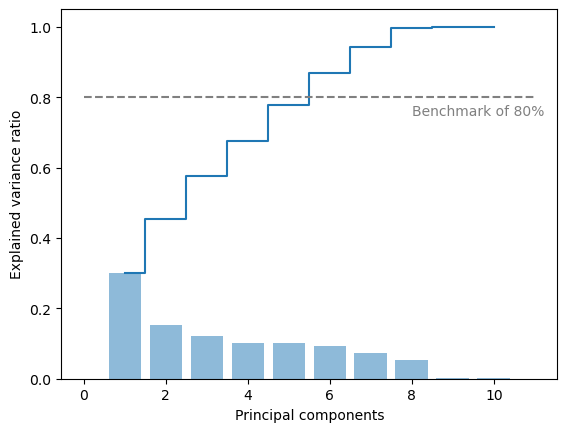

In [6]:
plt.bar(range(1, width+1), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, width+1), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.hlines(y = 0.8, xmin=0, xmax=width+1, colors='gray', linestyles='--')
plt.annotate("Benchmark of 80%", (8, 0.75), color="gray")
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

## LR with pipeline and grid search

In [7]:
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=6),
                        LogisticRegression(random_state=1))

param_range = [10**c for c in range(-4, 4)]

param_grid_lr = [{'logisticregression__C': param_range, 
                  'logisticregression__solver': ['lbfgs']},
                 {'logisticregression__C': param_range, 
                  'logisticregression__solver': ['newton-cholesky']}]


gs_lr = GridSearchCV(estimator=pipe_lr, 
                    param_grid=param_grid_lr, 
                    scoring='accuracy', 
                    refit=True,
                    cv=5,
                    n_jobs=-1)

gs_lr.fit(X_train, y_train)

print('The highest score is {:.4f} generated by parameters {}'.format(gs_lr.best_score_, gs_lr.best_params_))

classifier_lr = gs_lr.best_estimator_

print('Test accuracy of logistic regression is: %.4f' % classifier_lr.score(X_test, y_test_binary))

The highest score is 0.9333 generated by parameters {'logisticregression__C': 0.0001, 'logisticregression__solver': 'lbfgs'}
Test accuracy of logistic regression is: 0.9836


## SVM with pipeline and grid search

In [7]:
pipe_svc = make_pipeline(StandardScaler(),
                        PCA(n_components=6),
                        SVC(random_state=1))

param_range = [10**c for c in range(-2, 2)]

param_grid_svc = [{'svc__C': param_range, 
                   'svc__kernel': ['rbf']}]

gs_svc = GridSearchCV(estimator=pipe_svc, 
                      param_grid=param_grid_svc, 
                      scoring='accuracy', 
                      refit=True,
                      cv=5,
                      n_jobs=-1)

gs_svc.fit(X_train, y_train)

print('The highest score is {:.4f} generated by parameters {}'.format(gs_svc.best_score_, gs_svc.best_params_))

classifier_svc = gs_svc.best_estimator_

print('Test accuracy of SVM is: %.4f' % classifier_svc.score(X_test, y_test_binary))

The highest score is 0.9346 generated by parameters {'svc__C': 10, 'svc__kernel': 'rbf'}
Test accuracy of SVM is: 0.9869


## Decision Tree with pipeline and grid search

In [10]:
pipe_dt = make_pipeline(StandardScaler(),
                        PCA(n_components=6),
                        DecisionTreeClassifier(random_state=1))

depth_range = list(range(2, 6))

param_grid_dt = [{'decisiontreeclassifier__max_depth': depth_range,
                  'decisiontreeclassifier__criterion': ['gini']},
                 {'decisiontreeclassifier__max_depth': depth_range,
                  'decisiontreeclassifier__criterion': ['entropy']},
                 {'decisiontreeclassifier__max_depth': depth_range,
                  'decisiontreeclassifier__criterion': ['log_loss']}]

gs_dt = GridSearchCV(estimator=pipe_dt, 
                      param_grid=param_grid_dt, 
                      scoring='accuracy', 
                      refit=True,
                      cv=5,
                      n_jobs=-1)

gs_dt.fit(X_train, y_train)

print('The highest score is {:.4f} generated by parameters {}'.format(gs_dt.best_score_, gs_dt.best_params_))

classifier_dt = gs_dt.best_estimator_

print('Test accuracy of Decision Tree is: %.4f' % classifier_dt.score(X_test, y_test_binary))

The highest score is 0.9362 generated by parameters {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 4}
Test accuracy of Decision Tree is: 0.9880
